In [1]:
# Imports
from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

import torchvision
from torchvision.transforms import transforms

from utils import *
from data_loader import DepthDatasetLoader

print(torch.__version__)
print(torchvision.__version__)



/home/sangbeom/.pyenv/versions/3.8.8/envs/nerf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done.
1.10.1+cu111
0.11.2+cu111


In [2]:
root_path = root_path = "/home/sangbeom/resnet/data/depth1014/"

depth_dataset = DepthDatasetLoader(root_path=root_path)
train_set, val_set = train_val_split(depth_dataset, 0.1)


In [27]:
class ResBlock(nn.Module):
    """
    A two-convolutional layer residual block.
    """
    
    def __init__(self, c_in, c_out, k, s=1, p=1, mode='encode'):
        assert mode in ['encode', 'decode'], "Mode must be either 'encode' or 'decode'."
        super(ResBlock, self).__init__()
        if mode == 'encode':
            self.conv1 = nn.Conv2d(c_in, c_out, k, s, p)
            self.conv2 = nn.Conv2d(c_out, c_out, 3, 1, 1)
        elif mode == 'decode':
            self.conv1 = nn.ConvTranspose2d(c_in, c_out, k, s, p)
            self.conv2 = nn.ConvTranspose2d(c_out, c_out, 3, 1, 1)
        self.relu = nn.ReLU()
        self.BN = nn.BatchNorm2d(c_out)
        self.resize = s > 1 or (s == 1 and p == 0) or c_out != c_in
    
    def forward(self, x):
        conv1 = self.BN(self.conv1(x))
        relu = self.relu(conv1)
        conv2 = self.BN(self.conv2(relu))
        if self.resize:
            x = self.BN(self.conv1(x))
        return self.relu(x + conv2)

class Encoder(nn.Module):
    """
    Encoder class, mainly consisting of three residual blocks.
    """
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.init_conv = nn.Conv2d(1, 32, 1, 1, 0) # 16 32 32
        self.BN = nn.BatchNorm2d(32)
        self.rb1 = ResBlock(32, 32, 1, 2, 0, 'encode') # 16 16 16
        self.rb2 = ResBlock(32, 64, 1, 1, 1, 'encode') # 32 16 16
        self.rb3 = ResBlock(64, 64, 1, 2, 1, 'encode') # 32 8 8
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        print("inputs",inputs.shape)
        init_conv = self.relu(self.BN(self.init_conv(inputs)))
        rb1 = self.rb1(init_conv)
        print("Rb1",rb1.shape)
        rb2 = self.rb2(rb1)
        print("rb2",rb2.shape)
        rb3 = self.rb3(rb2)
        print("rb3",rb3.shape)
        return rb3

class Decoder(nn.Module):
    """
    Decoder class, mainly consisting of two residual blocks.
    """
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.rb4 = ResBlock(64, 64, 2, 2, 1, 'decode') # 32 16 16
        self.rb5 = ResBlock(64, 32, 3, 1, 1, 'decode') # 16 16 16
        self.rb6 = ResBlock(32, 32, 2, 2, 1, 'decode') # 16 32 32
        self.out_conv = nn.ConvTranspose2d(32, 1, 1, 1, 1) # 3 32 32
        self.tanh = nn.Tanh()
        
    def forward(self, inputs):
        rb4 = self.rb4(inputs)
        rb5 = self.rb5(rb4)
        rb6 = self.rb6(rb5)
        out_conv = self.out_conv(rb6)
        output = self.tanh(out_conv)
        return output

class Autoencoder(nn.Module):
    """
    Autoencoder class, combines encoder and decoder model.
    """
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    @property
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_p = sum([np.prod(p.size()) for p in model_parameters])
        return num_p
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded

In [28]:
print("Number of parameters in model: {0}".format(Autoencoder().num_params))

Number of parameters in model: 185633


In [29]:
param_names = ('init_lr', 'batch_size', 'weight_decay')
parameters = OrderedDict(
    run = [0.05, 32, 0.001],
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))
import matplotlib.pyplot as plt 

Device: cuda:0


Now training model with hyperparameters: init_lr=0.05, batch_size=32, weight_decay=0.001
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
Epoch 1, iteration 0: train loss 2.030319, val loss 2.048763


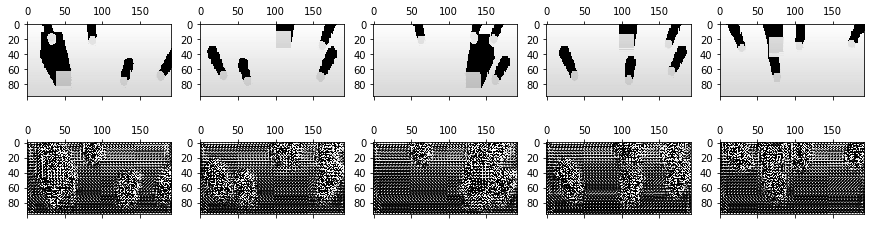

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

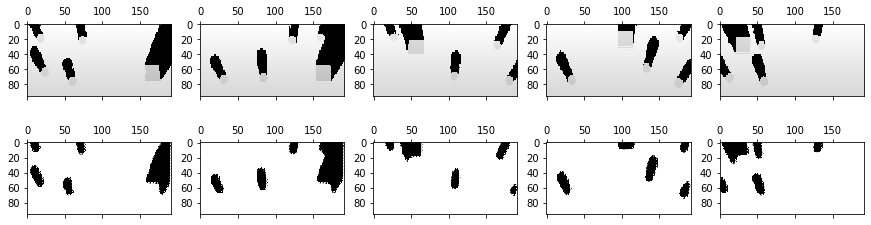

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

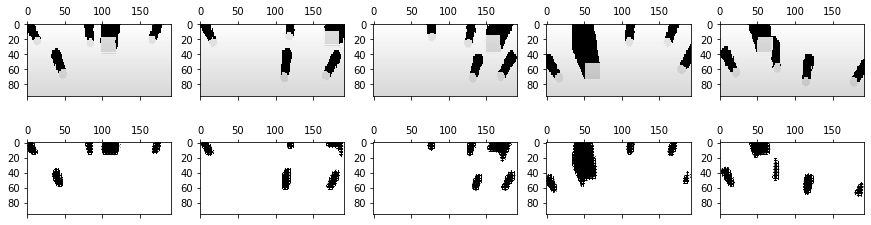

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

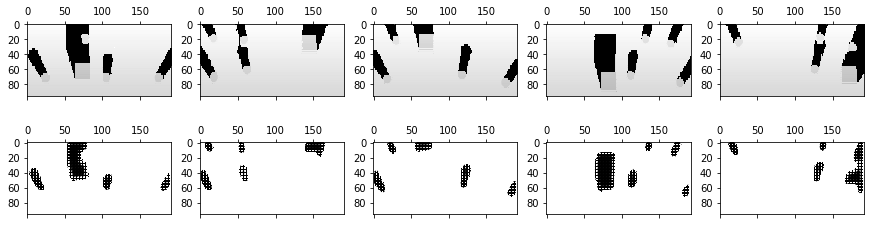

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

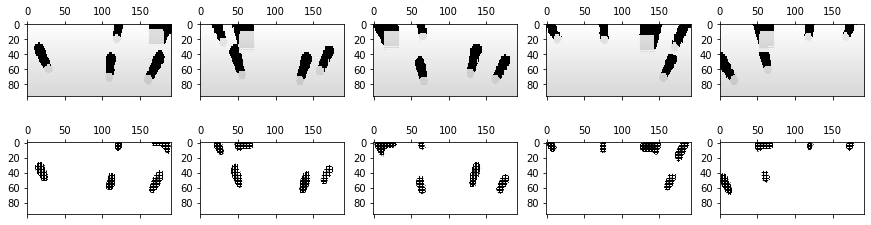

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

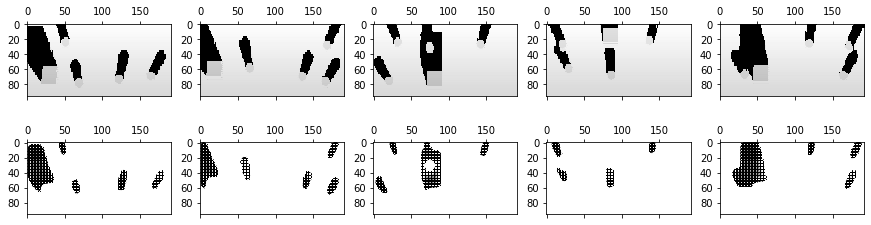

inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Size([32, 1, 96, 192])
Rb1 torch.Size([32, 32, 48, 96])
rb2 torch.Size([32, 64, 50, 98])
rb3 torch.Size([32, 64, 26, 50])
torch.Size([32, 64, 26, 50])
inputs torch.Siz

KeyboardInterrupt: 

In [30]:
m = RunManager()
num_epochs = 150

for hparams in RunBuilder.get_runs_from_params(param_names, parameters):

    # Instantiate a network model
    ae = Autoencoder().to(device)

    # Construct a DataLoader object with training data
    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hparams.batch_size, shuffle=True)
    test_loader = DataLoader(val_set, batch_size=10, shuffle=False)
    test_images = next(iter(test_loader))
    test_images = next(iter(val_loader))

    # Define optimizer
    optimizer = optim.SGD(ae.parameters(), lr=hparams.init_lr, momentum=0.9, weight_decay=hparams.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 60, 0.1)
    
    # Setup run instance
    # m.begin_run(hparams, ae, torch.Tensor(test_images).to(device))
    print('Now training model with hyperparameters: init_lr={0}, batch_size={1}, weight_decay={2}'
         .format(hparams.init_lr, hparams.batch_size, hparams.weight_decay))
    
    # Start training loop
    for epoch in range(num_epochs):
        # m.begin_epoch()
        
        # Train the model
        for i, batch in enumerate(train_loader):
            train_images = batch.reshape(-1, 1, 96, 192)
            train_images =  Variable(train_images.float().to(device))
            # Zero all gradients
            optimizer.zero_grad()
            
            # Calculating the loss
            preds = ae(train_images)
            loss = F.mse_loss(preds, train_images)
            
            if i % 10 == 0:
                with torch.no_grad():
                    val_images  = next(iter(val_loader))
                    val_images = val_images.reshape(-1, 1, 96, 192)
                    val_images = Variable(val_images.float().to(device))
                    val_preds = ae(val_images)
                    val_loss = F.mse_loss(val_preds, val_images)
                    m.track_loss(val_loss, val_images.size(0), mode='val')
                print('Epoch {0}, iteration {1}: train loss {2}, val loss {3}'.format(epoch+1,
                                                                               i*hparams.batch_size,
                                                                               round(loss.item(), 6),
                                                                               round(val_loss.item(), 6)))
                fig, axs = plt.subplots(2,5, figsize=(15,4))
                val_images = val_images.detach().cpu().numpy()
                val_preds = val_preds.detach().cpu().numpy()
                for i in range(5):
                    axs[0][i].matshow(np.reshape(val_images[i, :], (96,192)), cmap=plt.get_cmap('gray'))
                    axs[1][i].matshow(np.reshape(val_preds[i, :], (96,192)), cmap=plt.get_cmap('gray'))
                plt.show()
            # Backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # m.track_loss(loss, images.size(0), mode='train')
            
        # m.end_epoch()
    
    #torch.save(ae, './models/150epochs_' + str(hparams) + '.pth')
    # m.end_run()
    print("Model has finished training.\n")
    scheduler.step()
    
m.save('results_final')
print("Training completed.")